In [16]:
!pip install oandapy
!pip install v20
!pip install oandapyV20

    100% |████████████████████████████████| 61kB 626kB/s ta 0:00:01
  Running setup.py bdist_wheel for oandapyV20 ... done
  Stored in directory: /Users/Santi/Library/Caches/pip/wheels/2c/b0/cd/49054320a6cc51db0ff4f1ee15d8840375f16cef57b81ebfc0
Successfully built oandapyV20


In [3]:
# Importing the API, packages and configuring the access to the account

import configparser
import json
from oandapyV20 import API    
import oandapyV20.endpoints.trades as trades

config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

In [4]:
# Get a list of all instruments 
  
import oandapyV20.endpoints.accounts as accounts

r = accounts.AccountInstruments(accountID=config['oanda']['account_id'])
rv = client.request(r)
print(json.dumps(rv, indent=2))

{
  "instruments": [
    {
      "name": "XAU_EUR",
      "type": "METAL",
      "displayName": "Gold/EUR",
      "pipLocation": -2,
      "displayPrecision": 3,
      "tradeUnitsPrecision": 0,
      "minimumTradeSize": "1",
      "maximumTrailingStopDistance": "100.000",
      "minimumTrailingStopDistance": "0.050",
      "maximumPositionSize": "0",
      "maximumOrderUnits": "50000",
      "marginRate": "0.1",
      "tags": [
        {
          "type": "ASSET_CLASS",
          "name": "COMMODITY"
        }
      ]
    },
    {
      "name": "UK100_GBP",
      "type": "CFD",
      "displayName": "UK 100",
      "pipLocation": 0,
      "displayPrecision": 1,
      "tradeUnitsPrecision": 0,
      "minimumTradeSize": "1",
      "maximumTrailingStopDistance": "10000.0",
      "minimumTrailingStopDistance": "5.0",
      "maximumPositionSize": "0",
      "maximumOrderUnits": "500",
      "marginRate": "0.1",
      "tags": [
        {
          "type": "ASSET_CLASS",
          "name": "INDE

In [42]:
# Extract Data from the Trading Website

import pandas as pd
import datetime
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments

params={"from": parser.parse("2017-12-13 18:00:00 EDT").strftime('%s'), # Need to adapt the format of time 
        "to": parser.parse("2017-12-17 00:00:00 EDT").strftime('%s'),
        "granularity":'M1',
        "price":'A'}
r = instruments.InstrumentsCandles(instrument="DE30_EUR",params=params)
data = client.request(r) # Pulling the information from Oanda
results= [{"time":x['time'],"closeAsk":float(x['ask']['c'])} for x in data['candles']]
df = pd.DataFrame(results).set_index('time')

df.index = pd.DatetimeIndex(df.index)

df.info()

print(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1917 entries, 2017-12-13 17:00:00 to 2017-12-15 20:59:00
Data columns (total 1 columns):
closeAsk    1917 non-null float64
dtypes: float64(1)
memory usage: 30.0 KB
                     closeAsk
time                         
2017-12-13 17:00:00   13123.3
2017-12-13 17:01:00   13123.8
2017-12-13 17:02:00   13115.8
2017-12-13 17:03:00   13121.3
2017-12-13 17:04:00   13120.8
2017-12-13 17:05:00   13120.8
2017-12-13 17:06:00   13123.3
2017-12-13 17:07:00   13122.8
2017-12-13 17:08:00   13123.3
2017-12-13 17:09:00   13114.3
2017-12-13 17:10:00   13117.8
2017-12-13 17:11:00   13118.3
2017-12-13 17:12:00   13115.8
2017-12-13 17:13:00   13114.8
2017-12-13 17:14:00   13112.8
2017-12-13 17:15:00   13112.3
2017-12-13 17:16:00   13111.8
2017-12-13 17:17:00   13111.5
2017-12-13 17:18:00   13111.3
2017-12-13 17:19:00   13110.3
2017-12-13 17:20:00   13115.3
2017-12-13 17:21:00   13114.3
2017-12-13 17:22:00   13115.8
2017-12-13 17:23:00   13119.8
201

In [43]:
# Define function that will create a signal to buy or sell based on our strategy 

import pandas as pd
import numpy as np

def create_signals(data, MA1, MA2): # The short MA should be MA1 and long MA should be MA2
    signals = pd.DataFrame(index=data.index)
    signals['indication'] = 0.0
    
    signals['MovingA1'] = data.rolling(window = MA1).mean()
    signals['MovingA2'] = data.rolling(window = MA2).mean()
    
    signals['indication'] = np.where(signals['MovingA1'] > signals['MovingA2'], 1.0, 0.0) # base of our strategy
    MAd=MA2-1
    signals['indication'] = signals['indication'][MAd:]
    signals['positions'] = signals['indication'].diff() 
    
    return signals.shift(1)
    
Cross=create_signals(df, 5, 10)

print(Cross)

                     indication  MovingA1  MovingA2  positions
time                                                          
2017-12-13 17:00:00         NaN       NaN       NaN        NaN
2017-12-13 17:01:00         NaN       NaN       NaN        NaN
2017-12-13 17:02:00         NaN       NaN       NaN        NaN
2017-12-13 17:03:00         NaN       NaN       NaN        NaN
2017-12-13 17:04:00         NaN       NaN       NaN        NaN
2017-12-13 17:05:00         NaN  13121.00       NaN        NaN
2017-12-13 17:06:00         NaN  13120.50       NaN        NaN
2017-12-13 17:07:00         NaN  13120.40       NaN        NaN
2017-12-13 17:08:00         NaN  13121.80       NaN        NaN
2017-12-13 17:09:00         NaN  13122.20       NaN        NaN
2017-12-13 17:10:00         0.0  13120.90  13120.95        NaN
2017-12-13 17:11:00         0.0  13120.30  13120.40        0.0
2017-12-13 17:12:00         0.0  13119.30  13119.85        0.0
2017-12-13 17:13:00         0.0  13117.90  13119.85    

In [44]:
# Separate the buy and sell signals

Indexnames = Cross[Cross['positions'] == 0.0 ].index
cross = Cross.drop(Indexnames)

SIndexnames = cross[cross['positions'] == -1.0 ].index
Sellcross = cross.drop(SIndexnames)

BIndexnames = cross[cross['positions'] == 1.0 ].index
Buycross = cross.drop(BIndexnames)





In [45]:
# Format data before Plotting 

Buycross.index = pd.to_datetime(Buycross.index, dayfirst=True)
Sellcross.index = pd.to_datetime(Sellcross.index, dayfirst=True)
PositionsBuy = Buycross.dropna()
PositionsSell = Sellcross.dropna()


Text(0, 0.5, 'Price')

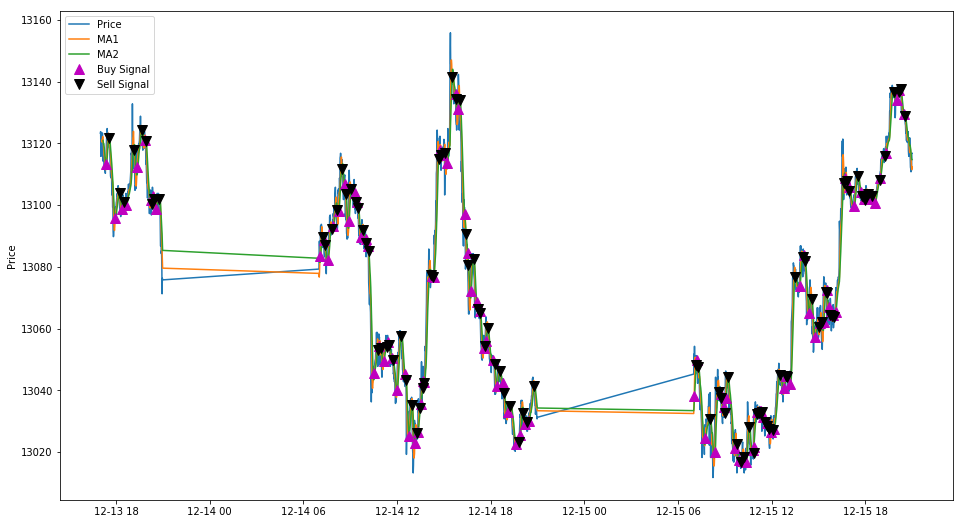

In [46]:
# Representation of the strategy 

import matplotlib.pyplot as plt

start_date = df.index[0]
end_date = df.index[-1]

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(df.index, df.loc[start_date:end_date, 'closeAsk'], label='Price')
ax.plot(df.index, Cross.loc[start_date:end_date, 'MovingA1'], label = 'MA1')

ax.plot(df.index, Cross.loc[start_date:end_date, 'MovingA2'], label = 'MA2')
ax.plot(PositionsSell.index, PositionsSell['MovingA1'], '^', markersize=10, color='m', label = 'Buy Signal')
ax.plot(PositionsBuy.index, PositionsBuy['MovingA1'], 'v', markersize=10, color='k', label = 'Sell Signal')

ax.legend(loc='best')
ax.set_ylabel('Price')

In [47]:
# Calculating Portfolio value if following the strategy or not

Cross['closeAsk'] = df['closeAsk']
Cross['Return'] = np.log(Cross['closeAsk'] / Cross['closeAsk'].shift(1))
Cross['Return1'] = Cross['indication']*Cross['Return']

Cross['Return1'].fillna(0, inplace = True)
Cross['Return'].fillna(0, inplace = True)

Valuation = list(Cross['Return1'])
Valuation2 = list(Cross['Return'])

def Value(inital, returntype):
    sum1 =[]
    sum = inital
    for i in returntype:
        sum = sum + i*sum
        sum1.append(sum)
        
    return sum1

Cross['Valuation'] = Value(1000, Valuation)
Cross['Valuation2'] = Value(1000, Valuation2)


Initial Value: 1000.0
Final value for buy and hold strategy: 999.4512776298981
Final value for our strategy: 1003.5035654213478


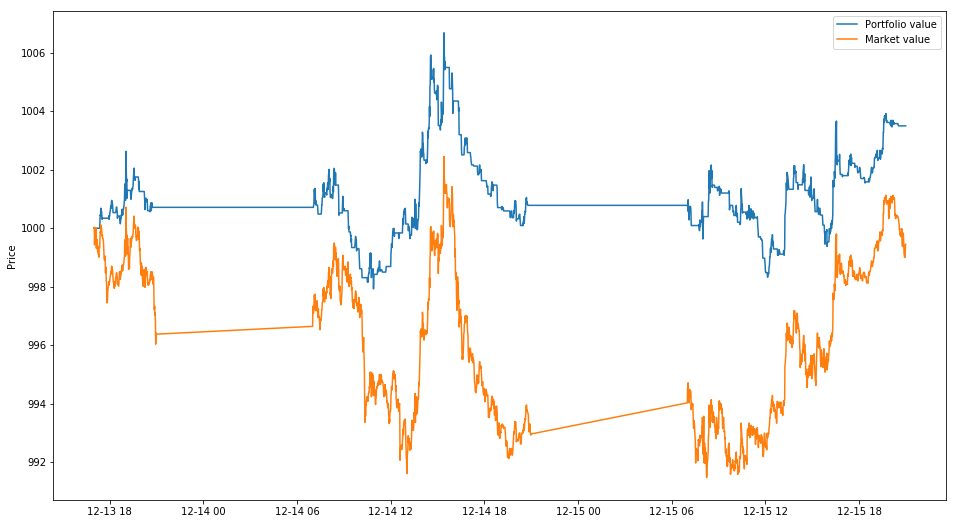

In [48]:
# Plotting Portfolio values

fig, ax = plt.subplots(figsize=(16,9))

ax.plot(df.index, Cross.loc[start_date:end_date, 'Valuation'], label='Portfolio value')
ax.plot(df.index, Cross.loc[start_date:end_date, 'Valuation2'], label='Market value')

ax.legend(loc='best')
ax.set_ylabel('Price')

print('Initial Value:',Cross['Valuation'].iloc[0] )
print('Final value for buy and hold strategy:',Cross['Valuation2'].iloc[-1] )
print('Final value for our strategy:',Cross['Valuation'].iloc[-1] )

In [52]:
# Automated Trading

from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oandapyV20.exceptions import V20Error, StreamTerminated
        
class MomentumTrader(PricingStream): # Create Class that will inherit a class from the API in order to display live prices
    def __init__(self, mashort, malong,  *args, **kwargs): 
        PricingStream.__init__(self, *args, **kwargs)
        self.ticks = 0 
        self.position = 0
        self.df = pd.DataFrame()
        self.mashort = mashort
        self.malong = malong
        self.units = 1
        self.connected = False
        self.client = API(access_token=config['oanda']['access_token'])
    def create_order(self, units): # Creating the order for our account
        order = orders.OrderCreate(accountID=config['oanda']['account_id'], data=MarketOrderRequest(instrument="DE30_EUR", units=units).data)
        response = self.client.request(order)
        print('\t', response)
    def on_success(self, data): # Implementing the strategy that will trigger orders
        self.ticks += 1
        print("ticks=",self.ticks) 
        self.df = self.df.append(pd.DataFrame([{'time': data['time'],'closeoutAsk':data['closeoutAsk']}],
                                 index=[data["time"]])) 
        
        self.df.index = pd.DatetimeIndex(self.df["time"]) 
        
        self.df['closeoutAsk'] = pd.to_numeric(self.df["closeoutAsk"],errors='ignore') 
      
        dfr = self.df.resample('5s').last().bfill()  
        
        # Strategy
        
        signals = pd.DataFrame(index=dfr.index)
        signals['indication'] = 0.0
    
        signals['MovingA1'] = dfr['closeoutAsk'].rolling(window = self.mashort).mean()
        signals['MovingA2'] = dfr['closeoutAsk'].rolling(window = self.malong).mean()
    
        signals['indication'] = np.where(signals['MovingA1'] > signals['MovingA2'], 1.0, 0.0)
        MAd=self.malong-1
        
        signals['indication'] = signals['indication'][MAd:]
        signals['positions'] = signals['indication'].diff() 
        signals['positions'] = signals['positions'].shift()
        
        # Orders given the signals
                                       
        print("position=",signals['positions'].iloc[-1])
        if signals['positions'].iloc[-1] == 1:
            print("go long")
            if self.position == 0:
                self.create_order(self.units)
            elif self.position == -1:
                self.create_order(self.units * 2)
            self.position = 1
        elif signals['positions'].iloc[-1] == -1:
            print("go short")
            if self.position == 0:
                self.create_order(-self.units)
            elif self.position == 1:
                self.create_order(-self.units * 2)
            self.position = -1
        if self.ticks == 1000:
            print("close out the position")
            if self.position == 1:
                self.create_order(-self.units)
            elif self.position == -1:
                self.create_order(self.units)
            self.disconnect()
    def disconnect(self):
        self.connected=False
    def rates(self, account_id, instruments, **params):
        self.connected = True
        params = params or {}
        ignore_heartbeat = None
        if "ignore_heartbeat" in params:
            ignore_heartbeat = params['ignore_heartbeat']
        while self.connected:
            response = self.client.request(self)
            for tick in response:
                if not self.connected:
                    break
                if not (ignore_heartbeat and tick["type"]=="HEARTBEAT"):
                    print(tick)
                    self.on_success(tick)

In [53]:
mt = MomentumTrader(mashort = 5, malong = 20, accountID=config['oanda']['account_id'],params={"instruments": "DE30_EUR"})
mt.rates(account_id=config['oanda']['account_id'], instruments="DE30_EUR", ignore_heartbeat=True)


{'type': 'PRICE', 'time': '2019-05-24T13:38:33.360545767Z', 'bids': [{'price': '12049.4', 'liquidity': 25}, {'price': '12049.3', 'liquidity': 25}, {'price': '12049.2', 'liquidity': 50}, {'price': '12049.0', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'asks': [{'price': '12050.8', 'liquidity': 50}, {'price': '12050.9', 'liquidity': 50}, {'price': '12051.1', 'liquidity': 50}, {'price': '12051.3', 'liquidity': 50}], 'closeoutBid': '12048.8', 'closeoutAsk': '12051.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 1
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:38:34.319340823Z', 'bids': [{'price': '12049.6', 'liquidity': 25}, {'price': '12049.5', 'liquidity': 25}, {'price': '12049.4', 'liquidity': 50}, {'price': '12049.2', 'liquidity': 50}, {'price': '12049.0', 'liquidity': 50}], 'asks': [{'price': '12051.0', 'liquidity': 50}, {'price': '12051.1', 'liquidity': 50}, {'price': '12051.3', 'liquidity': 50}, {'price': '12051.5', 'liquidity': 5

{'type': 'PRICE', 'time': '2019-05-24T13:38:45.091681979Z', 'bids': [{'price': '12048.1', 'liquidity': 25}, {'price': '12048.0', 'liquidity': 25}, {'price': '12047.9', 'liquidity': 50}, {'price': '12047.7', 'liquidity': 50}, {'price': '12047.5', 'liquidity': 50}], 'asks': [{'price': '12049.0', 'liquidity': 50}, {'price': '12049.1', 'liquidity': 50}, {'price': '12049.3', 'liquidity': 50}, {'price': '12049.5', 'liquidity': 50}], 'closeoutBid': '12047.5', 'closeoutAsk': '12049.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 16
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:38:45.711344099Z', 'bids': [{'price': '12048.4', 'liquidity': 25}, {'price': '12048.3', 'liquidity': 25}, {'price': '12048.2', 'liquidity': 50}, {'price': '12048.0', 'liquidity': 50}, {'price': '12047.8', 'liquidity': 50}], 'asks': [{'price': '12049.8', 'liquidity': 50}, {'price': '12049.9', 'liquidity': 50}, {'price': '12050.1', 'liquidity': 50}, {'price': '12050.3', 'liquidity': 

{'type': 'PRICE', 'time': '2019-05-24T13:38:53.948682980Z', 'bids': [{'price': '12048.9', 'liquidity': 25}, {'price': '12048.8', 'liquidity': 25}, {'price': '12048.7', 'liquidity': 50}, {'price': '12048.5', 'liquidity': 50}, {'price': '12048.3', 'liquidity': 50}], 'asks': [{'price': '12050.3', 'liquidity': 50}, {'price': '12050.4', 'liquidity': 50}, {'price': '12050.6', 'liquidity': 50}, {'price': '12050.8', 'liquidity': 50}], 'closeoutBid': '12048.3', 'closeoutAsk': '12050.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 32
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:38:53.996057037Z', 'bids': [{'price': '12048.9', 'liquidity': 25}, {'price': '12048.8', 'liquidity': 25}, {'price': '12048.7', 'liquidity': 50}, {'price': '12048.5', 'liquidity': 50}, {'price': '12048.3', 'liquidity': 50}], 'asks': [{'price': '12049.8', 'liquidity': 50}, {'price': '12049.9', 'liquidity': 50}, {'price': '12050.1', 'liquidity': 50}, {'price': '12050.3', 'liquidity': 

{'type': 'PRICE', 'time': '2019-05-24T13:39:01.278301888Z', 'bids': [{'price': '12048.9', 'liquidity': 25}, {'price': '12048.8', 'liquidity': 25}, {'price': '12048.7', 'liquidity': 50}, {'price': '12048.5', 'liquidity': 50}, {'price': '12048.3', 'liquidity': 50}], 'asks': [{'price': '12050.3', 'liquidity': 50}, {'price': '12050.4', 'liquidity': 50}, {'price': '12050.6', 'liquidity': 50}, {'price': '12050.8', 'liquidity': 50}], 'closeoutBid': '12048.3', 'closeoutAsk': '12050.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 47
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:39:02.168007978Z', 'bids': [{'price': '12048.6', 'liquidity': 25}, {'price': '12048.5', 'liquidity': 25}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.2', 'liquidity': 50}, {'price': '12048.0', 'liquidity': 50}], 'asks': [{'price': '12050.0', 'liquidity': 50}, {'price': '12050.1', 'liquidity': 50}, {'price': '12050.3', 'liquidity': 50}, {'price': '12050.5', 'liquidity': 

position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:39:07.638706842Z', 'bids': [{'price': '12049.4', 'liquidity': 25}, {'price': '12049.3', 'liquidity': 25}, {'price': '12049.2', 'liquidity': 50}, {'price': '12049.0', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'asks': [{'price': '12050.3', 'liquidity': 50}, {'price': '12050.4', 'liquidity': 50}, {'price': '12050.6', 'liquidity': 50}, {'price': '12050.8', 'liquidity': 50}], 'closeoutBid': '12048.8', 'closeoutAsk': '12050.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 62
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:39:08.046200415Z', 'bids': [{'price': '12049.6', 'liquidity': 25}, {'price': '12049.5', 'liquidity': 25}, {'price': '12049.4', 'liquidity': 50}, {'price': '12049.2', 'liquidity': 50}, {'price': '12049.0', 'liquidity': 50}], 'asks': [{'price': '12050.5', 'liquidity': 50}, {'price': '12050.6', 'liquidity': 50}, {'price': '12050.8', 'liquidity': 50}, {'price': '12051.0',

{'type': 'PRICE', 'time': '2019-05-24T13:39:14.623267856Z', 'bids': [{'price': '12050.4', 'liquidity': 25}, {'price': '12050.3', 'liquidity': 25}, {'price': '12050.2', 'liquidity': 50}, {'price': '12050.0', 'liquidity': 50}, {'price': '12049.8', 'liquidity': 50}], 'asks': [{'price': '12051.3', 'liquidity': 50}, {'price': '12051.4', 'liquidity': 50}, {'price': '12051.6', 'liquidity': 50}, {'price': '12051.8', 'liquidity': 50}], 'closeoutBid': '12049.8', 'closeoutAsk': '12051.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 77
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:39:14.760866665Z', 'bids': [{'price': '12050.1', 'liquidity': 25}, {'price': '12050.0', 'liquidity': 25}, {'price': '12049.9', 'liquidity': 50}, {'price': '12049.7', 'liquidity': 50}, {'price': '12049.5', 'liquidity': 50}], 'asks': [{'price': '12051.0', 'liquidity': 50}, {'price': '12051.1', 'liquidity': 50}, {'price': '12051.3', 'liquidity': 50}, {'price': '12051.5', 'liquidity': 

{'type': 'PRICE', 'time': '2019-05-24T13:39:22.011895297Z', 'bids': [{'price': '12051.6', 'liquidity': 25}, {'price': '12051.5', 'liquidity': 25}, {'price': '12051.4', 'liquidity': 50}, {'price': '12051.2', 'liquidity': 50}, {'price': '12051.0', 'liquidity': 50}], 'asks': [{'price': '12053.0', 'liquidity': 50}, {'price': '12053.1', 'liquidity': 50}, {'price': '12053.3', 'liquidity': 50}, {'price': '12053.5', 'liquidity': 50}], 'closeoutBid': '12051.0', 'closeoutAsk': '12053.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 92
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:39:23.207969846Z', 'bids': [{'price': '12051.4', 'liquidity': 25}, {'price': '12051.3', 'liquidity': 25}, {'price': '12051.2', 'liquidity': 50}, {'price': '12051.0', 'liquidity': 50}, {'price': '12050.8', 'liquidity': 50}], 'asks': [{'price': '12052.8', 'liquidity': 50}, {'price': '12052.9', 'liquidity': 50}, {'price': '12053.1', 'liquidity': 50}, {'price': '12053.3', 'liquidity': 

{'type': 'PRICE', 'time': '2019-05-24T13:39:32.269516408Z', 'bids': [{'price': '12050.7', 'liquidity': 25}, {'price': '12050.6', 'liquidity': 25}, {'price': '12050.5', 'liquidity': 50}, {'price': '12050.3', 'liquidity': 50}, {'price': '12050.1', 'liquidity': 50}], 'asks': [{'price': '12052.1', 'liquidity': 50}, {'price': '12052.2', 'liquidity': 50}, {'price': '12052.4', 'liquidity': 50}, {'price': '12052.6', 'liquidity': 50}], 'closeoutBid': '12050.1', 'closeoutAsk': '12052.6', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 107
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:39:33.181290565Z', 'bids': [{'price': '12049.9', 'liquidity': 25}, {'price': '12049.8', 'liquidity': 25}, {'price': '12049.7', 'liquidity': 50}, {'price': '12049.5', 'liquidity': 50}, {'price': '12049.3', 'liquidity': 50}], 'asks': [{'price': '12051.3', 'liquidity': 50}, {'price': '12051.4', 'liquidity': 50}, {'price': '12051.6', 'liquidity': 50}, {'price': '12051.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:39:39.532949498Z', 'bids': [{'price': '12049.1', 'liquidity': 25}, {'price': '12049.0', 'liquidity': 25}, {'price': '12048.9', 'liquidity': 50}, {'price': '12048.7', 'liquidity': 50}, {'price': '12048.5', 'liquidity': 50}], 'asks': [{'price': '12050.5', 'liquidity': 50}, {'price': '12050.6', 'liquidity': 50}, {'price': '12050.8', 'liquidity': 50}, {'price': '12051.0', 'liquidity': 50}], 'closeoutBid': '12048.5', 'closeoutAsk': '12051.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 122
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:39:39.917657668Z', 'bids': [{'price': '12049.4', 'liquidity': 25}, {'price': '12049.3', 'liquidity': 25}, {'price': '12049.2', 'liquidity': 50}, {'price': '12049.0', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'asks': [{'price': '12050.3', 'liquidity': 50}, {'price': '12050.4', 'liquidity': 50}, {'price': '12050.6', 'liquidity': 50}, {'price': '12050.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:39:47.291388905Z', 'bids': [{'price': '12048.4', 'liquidity': 25}, {'price': '12048.3', 'liquidity': 25}, {'price': '12048.2', 'liquidity': 50}, {'price': '12048.0', 'liquidity': 50}, {'price': '12047.8', 'liquidity': 50}], 'asks': [{'price': '12049.8', 'liquidity': 50}, {'price': '12049.9', 'liquidity': 50}, {'price': '12050.1', 'liquidity': 50}, {'price': '12050.3', 'liquidity': 50}], 'closeoutBid': '12047.8', 'closeoutAsk': '12050.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 137
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:39:47.852099815Z', 'bids': [{'price': '12048.1', 'liquidity': 25}, {'price': '12048.0', 'liquidity': 25}, {'price': '12047.9', 'liquidity': 50}, {'price': '12047.7', 'liquidity': 50}, {'price': '12047.5', 'liquidity': 50}], 'asks': [{'price': '12049.5', 'liquidity': 50}, {'price': '12049.6', 'liquidity': 50}, {'price': '12049.8', 'liquidity': 50}, {'price': '12050.0', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:39:53.620960514Z', 'bids': [{'price': '12046.1', 'liquidity': 25}, {'price': '12046.0', 'liquidity': 25}, {'price': '12045.9', 'liquidity': 50}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}], 'asks': [{'price': '12047.5', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity': 50}, {'price': '12048.0', 'liquidity': 50}], 'closeoutBid': '12045.5', 'closeoutAsk': '12048.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 152
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:39:54.553572558Z', 'bids': [{'price': '12045.9', 'liquidity': 25}, {'price': '12045.8', 'liquidity': 25}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:39:59.399450910Z', 'bids': [{'price': '12046.4', 'liquidity': 25}, {'price': '12046.3', 'liquidity': 25}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity': 50}], 'closeoutBid': '12045.8', 'closeoutAsk': '12047.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 167
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:39:59.662374150Z', 'bids': [{'price': '12046.1', 'liquidity': 25}, {'price': '12046.0', 'liquidity': 25}, {'price': '12045.9', 'liquidity': 50}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}], 'asks': [{'price': '12047.0', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity': 50}, {'price': '12047.5', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:40:05.421608225Z', 'bids': [{'price': '12046.9', 'liquidity': 25}, {'price': '12046.8', 'liquidity': 25}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'closeoutBid': '12046.3', 'closeoutAsk': '12048.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 182
position= nan
{'type': 'PRICE', 'time': '2019-05-24T13:40:05.624885763Z', 'bids': [{'price': '12046.9', 'liquidity': 25}, {'price': '12046.8', 'liquidity': 25}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:40:15.704276778Z', 'bids': [{'price': '12046.4', 'liquidity': 25}, {'price': '12046.3', 'liquidity': 25}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}], 'asks': [{'price': '12047.8', 'liquidity': 50}, {'price': '12047.9', 'liquidity': 50}, {'price': '12048.1', 'liquidity': 50}, {'price': '12048.3', 'liquidity': 50}], 'closeoutBid': '12045.8', 'closeoutAsk': '12048.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 197
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:40:16.020791390Z', 'bids': [{'price': '12046.4', 'liquidity': 25}, {'price': '12046.3', 'liquidity': 25}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}], 'asks': [{'price': '12047.8', 'liquidity': 50}, {'price': '12047.9', 'liquidity': 50}, {'price': '12048.1', 'liquidity': 50}, {'price': '12048.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:40:29.454058994Z', 'bids': [{'price': '12046.4', 'liquidity': 25}, {'price': '12046.3', 'liquidity': 25}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}], 'asks': [{'price': '12047.8', 'liquidity': 50}, {'price': '12047.9', 'liquidity': 50}, {'price': '12048.1', 'liquidity': 50}, {'price': '12048.3', 'liquidity': 50}], 'closeoutBid': '12045.8', 'closeoutAsk': '12048.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 212
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:40:29.881398880Z', 'bids': [{'price': '12046.4', 'liquidity': 25}, {'price': '12046.3', 'liquidity': 25}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}], 'asks': [{'price': '12047.8', 'liquidity': 50}, {'price': '12047.9', 'liquidity': 50}, {'price': '12048.1', 'liquidity': 50}, {'price': '12048.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:40:38.467211024Z', 'bids': [{'price': '12047.1', 'liquidity': 25}, {'price': '12047.0', 'liquidity': 25}, {'price': '12046.9', 'liquidity': 50}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}], 'asks': [{'price': '12048.5', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}, {'price': '12049.0', 'liquidity': 50}], 'closeoutBid': '12046.5', 'closeoutAsk': '12049.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 227
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:40:38.809876723Z', 'bids': [{'price': '12046.9', 'liquidity': 25}, {'price': '12046.8', 'liquidity': 25}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:40:45.372757308Z', 'bids': [{'price': '12047.1', 'liquidity': 25}, {'price': '12047.0', 'liquidity': 25}, {'price': '12046.9', 'liquidity': 50}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}], 'asks': [{'price': '12048.5', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}, {'price': '12049.0', 'liquidity': 50}], 'closeoutBid': '12046.5', 'closeoutAsk': '12049.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 242
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:40:45.527434342Z', 'bids': [{'price': '12046.9', 'liquidity': 25}, {'price': '12046.8', 'liquidity': 25}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:40:55.447071953Z', 'bids': [{'price': '12045.9', 'liquidity': 25}, {'price': '12045.8', 'liquidity': 25}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity': 50}], 'closeoutBid': '12045.3', 'closeoutAsk': '12047.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 257
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:40:55.948887992Z', 'bids': [{'price': '12045.6', 'liquidity': 25}, {'price': '12045.5', 'liquidity': 25}, {'price': '12045.4', 'liquidity': 50}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}], 'asks': [{'price': '12047.0', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity': 50}, {'price': '12047.5', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:41:04.024141382Z', 'bids': [{'price': '12045.9', 'liquidity': 25}, {'price': '12045.8', 'liquidity': 25}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'asks': [{'price': '12046.8', 'liquidity': 50}, {'price': '12046.9', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity': 50}], 'closeoutBid': '12045.3', 'closeoutAsk': '12047.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 272
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:41:04.683308784Z', 'bids': [{'price': '12045.4', 'liquidity': 25}, {'price': '12045.3', 'liquidity': 25}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}, {'price': '12044.8', 'liquidity': 50}], 'asks': [{'price': '12046.8', 'liquidity': 50}, {'price': '12046.9', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:41:12.032463313Z', 'bids': [{'price': '12046.6', 'liquidity': 25}, {'price': '12046.5', 'liquidity': 25}, {'price': '12046.4', 'liquidity': 50}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}], 'asks': [{'price': '12048.0', 'liquidity': 50}, {'price': '12048.1', 'liquidity': 50}, {'price': '12048.3', 'liquidity': 50}, {'price': '12048.5', 'liquidity': 50}], 'closeoutBid': '12046.0', 'closeoutAsk': '12048.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 287
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:41:12.678310478Z', 'bids': [{'price': '12046.4', 'liquidity': 25}, {'price': '12046.3', 'liquidity': 25}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}], 'asks': [{'price': '12047.8', 'liquidity': 50}, {'price': '12047.9', 'liquidity': 50}, {'price': '12048.1', 'liquidity': 50}, {'price': '12048.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:41:20.660714810Z', 'bids': [{'price': '12047.4', 'liquidity': 25}, {'price': '12047.3', 'liquidity': 25}, {'price': '12047.2', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'closeoutBid': '12046.8', 'closeoutAsk': '12048.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 302
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:41:20.857012418Z', 'bids': [{'price': '12047.6', 'liquidity': 25}, {'price': '12047.5', 'liquidity': 25}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.2', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}], 'asks': [{'price': '12048.5', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}, {'price': '12049.0', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:41:28.763685738Z', 'bids': [{'price': '12045.6', 'liquidity': 25}, {'price': '12045.5', 'liquidity': 25}, {'price': '12045.4', 'liquidity': 50}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}], 'asks': [{'price': '12046.5', 'liquidity': 50}, {'price': '12046.6', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}], 'closeoutBid': '12045.0', 'closeoutAsk': '12047.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 317
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:41:28.785933227Z', 'bids': [{'price': '12045.4', 'liquidity': 25}, {'price': '12045.3', 'liquidity': 25}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}, {'price': '12044.8', 'liquidity': 50}], 'asks': [{'price': '12046.3', 'liquidity': 50}, {'price': '12046.4', 'liquidity': 50}, {'price': '12046.6', 'liquidity': 50}, {'price': '12046.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:41:33.710366832Z', 'bids': [{'price': '12043.9', 'liquidity': 25}, {'price': '12043.8', 'liquidity': 25}, {'price': '12043.7', 'liquidity': 50}, {'price': '12043.5', 'liquidity': 50}, {'price': '12043.3', 'liquidity': 50}], 'asks': [{'price': '12044.8', 'liquidity': 50}, {'price': '12044.9', 'liquidity': 50}, {'price': '12045.1', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'closeoutBid': '12043.3', 'closeoutAsk': '12045.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 332
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:41:33.802557022Z', 'bids': [{'price': '12043.6', 'liquidity': 25}, {'price': '12043.5', 'liquidity': 25}, {'price': '12043.4', 'liquidity': 50}, {'price': '12043.2', 'liquidity': 50}, {'price': '12043.0', 'liquidity': 50}], 'asks': [{'price': '12044.5', 'liquidity': 50}, {'price': '12044.6', 'liquidity': 50}, {'price': '12044.8', 'liquidity': 50}, {'price': '12045.0', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:41:40.226362596Z', 'bids': [{'price': '12044.4', 'liquidity': 25}, {'price': '12044.3', 'liquidity': 25}, {'price': '12044.2', 'liquidity': 50}, {'price': '12044.0', 'liquidity': 50}, {'price': '12043.8', 'liquidity': 50}], 'asks': [{'price': '12045.8', 'liquidity': 50}, {'price': '12045.9', 'liquidity': 50}, {'price': '12046.1', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'closeoutBid': '12043.8', 'closeoutAsk': '12046.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 347
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:41:40.510132424Z', 'bids': [{'price': '12044.4', 'liquidity': 25}, {'price': '12044.3', 'liquidity': 25}, {'price': '12044.2', 'liquidity': 50}, {'price': '12044.0', 'liquidity': 50}, {'price': '12043.8', 'liquidity': 50}], 'asks': [{'price': '12045.8', 'liquidity': 50}, {'price': '12045.9', 'liquidity': 50}, {'price': '12046.1', 'liquidity': 50}, {'price': '12046.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:41:45.388675374Z', 'bids': [{'price': '12046.1', 'liquidity': 25}, {'price': '12046.0', 'liquidity': 25}, {'price': '12045.9', 'liquidity': 50}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}], 'asks': [{'price': '12047.5', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity': 50}, {'price': '12048.0', 'liquidity': 50}], 'closeoutBid': '12045.5', 'closeoutAsk': '12048.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 362
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:41:45.647506201Z', 'bids': [{'price': '12045.9', 'liquidity': 25}, {'price': '12045.8', 'liquidity': 25}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:41:54.547002983Z', 'bids': [{'price': '12045.6', 'liquidity': 25}, {'price': '12045.5', 'liquidity': 25}, {'price': '12045.4', 'liquidity': 50}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}], 'asks': [{'price': '12047.0', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity': 50}, {'price': '12047.5', 'liquidity': 50}], 'closeoutBid': '12045.0', 'closeoutAsk': '12047.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 377
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:41:54.661584819Z', 'bids': [{'price': '12045.9', 'liquidity': 25}, {'price': '12045.8', 'liquidity': 25}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:42:01.243615540Z', 'bids': [{'price': '12044.9', 'liquidity': 25}, {'price': '12044.8', 'liquidity': 25}, {'price': '12044.7', 'liquidity': 50}, {'price': '12044.5', 'liquidity': 50}, {'price': '12044.3', 'liquidity': 50}], 'asks': [{'price': '12046.3', 'liquidity': 50}, {'price': '12046.4', 'liquidity': 50}, {'price': '12046.6', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}], 'closeoutBid': '12044.3', 'closeoutAsk': '12046.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 392
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:42:01.536151915Z', 'bids': [{'price': '12044.9', 'liquidity': 25}, {'price': '12044.8', 'liquidity': 25}, {'price': '12044.7', 'liquidity': 50}, {'price': '12044.5', 'liquidity': 50}, {'price': '12044.3', 'liquidity': 50}], 'asks': [{'price': '12046.3', 'liquidity': 50}, {'price': '12046.4', 'liquidity': 50}, {'price': '12046.6', 'liquidity': 50}, {'price': '12046.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:42:09.585770039Z', 'bids': [{'price': '12046.9', 'liquidity': 25}, {'price': '12046.8', 'liquidity': 25}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'closeoutBid': '12046.3', 'closeoutAsk': '12048.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 407
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:42:09.653137958Z', 'bids': [{'price': '12046.9', 'liquidity': 25}, {'price': '12046.8', 'liquidity': 25}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'asks': [{'price': '12047.8', 'liquidity': 50}, {'price': '12047.9', 'liquidity': 50}, {'price': '12048.1', 'liquidity': 50}, {'price': '12048.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:42:20.615052462Z', 'bids': [{'price': '12047.6', 'liquidity': 25}, {'price': '12047.5', 'liquidity': 25}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.2', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}], 'asks': [{'price': '12048.5', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}, {'price': '12049.0', 'liquidity': 50}], 'closeoutBid': '12047.0', 'closeoutAsk': '12049.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 422
position= 1.0
go long
	 {'orderCreateTransaction': {'type': 'MARKET_ORDER', 'instrument': 'DE30_EUR', 'units': '1', 'timeInForce': 'FOK', 'positionFill': 'DEFAULT', 'reason': 'CLIENT_ORDER', 'id': '119', 'accountID': '101-004-11199400-001', 'userID': 11199400, 'batchID': '119', 'requestID': '78595278085368209', 'time': '2019-05-24T13:42:21.240033457Z'}, 'orderFillTransaction': {'type': 'ORDER_FILL', 'orderID': '119', 'instrument': 'DE

{'type': 'PRICE', 'time': '2019-05-24T13:42:27.557392731Z', 'bids': [{'price': '12046.9', 'liquidity': 25}, {'price': '12046.8', 'liquidity': 25}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'closeoutBid': '12046.3', 'closeoutAsk': '12048.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 434
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:42:28.333113521Z', 'bids': [{'price': '12046.9', 'liquidity': 25}, {'price': '12046.8', 'liquidity': 25}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:42:38.897233568Z', 'bids': [{'price': '12041.5', 'liquidity': 25}, {'price': '12041.4', 'liquidity': 25}, {'price': '12041.3', 'liquidity': 50}, {'price': '12041.1', 'liquidity': 50}, {'price': '12040.9', 'liquidity': 50}], 'asks': [{'price': '12042.4', 'liquidity': 50}, {'price': '12042.5', 'liquidity': 50}, {'price': '12042.7', 'liquidity': 50}, {'price': '12042.9', 'liquidity': 50}], 'closeoutBid': '12040.9', 'closeoutAsk': '12042.9', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 450
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:42:39.117517254Z', 'bids': [{'price': '12042.4', 'liquidity': 25}, {'price': '12042.3', 'liquidity': 25}, {'price': '12042.2', 'liquidity': 50}, {'price': '12042.0', 'liquidity': 50}, {'price': '12041.8', 'liquidity': 50}], 'asks': [{'price': '12043.8', 'liquidity': 50}, {'price': '12043.9', 'liquidity': 50}, {'price': '12044.1', 'liquidity': 50}, {'price': '12044.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:42:44.171907148Z', 'bids': [{'price': '12044.1', 'liquidity': 25}, {'price': '12044.0', 'liquidity': 25}, {'price': '12043.9', 'liquidity': 50}, {'price': '12043.7', 'liquidity': 50}, {'price': '12043.5', 'liquidity': 50}], 'asks': [{'price': '12045.5', 'liquidity': 50}, {'price': '12045.6', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}], 'closeoutBid': '12043.5', 'closeoutAsk': '12046.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 465
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:42:44.808058244Z', 'bids': [{'price': '12044.4', 'liquidity': 25}, {'price': '12044.3', 'liquidity': 25}, {'price': '12044.2', 'liquidity': 50}, {'price': '12044.0', 'liquidity': 50}, {'price': '12043.8', 'liquidity': 50}], 'asks': [{'price': '12045.8', 'liquidity': 50}, {'price': '12045.9', 'liquidity': 50}, {'price': '12046.1', 'liquidity': 50}, {'price': '12046.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:42:48.127017296Z', 'bids': [{'price': '12043.4', 'liquidity': 25}, {'price': '12043.3', 'liquidity': 25}, {'price': '12043.2', 'liquidity': 50}, {'price': '12043.0', 'liquidity': 50}, {'price': '12042.8', 'liquidity': 50}], 'asks': [{'price': '12044.8', 'liquidity': 50}, {'price': '12044.9', 'liquidity': 50}, {'price': '12045.1', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'closeoutBid': '12042.8', 'closeoutAsk': '12045.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 476
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-24T13:42:48.332659719Z', 'bids': [{'price': '12043.4', 'liquidity': 25}, {'price': '12043.3', 'liquidity': 25}, {'price': '12043.2', 'liquidity': 50}, {'price': '12043.0', 'liquidity': 50}, {'price': '12042.8', 'liquidity': 50}], 'asks': [{'price': '12044.3', 'liquidity': 50}, {'price': '12044.4', 'liquidity': 50}, {'price': '12044.6', 'liquidity': 50}, {'price': '12044.8', 'l

{'type': 'PRICE', 'time': '2019-05-24T13:42:54.087054990Z', 'bids': [{'price': '12043.6', 'liquidity': 25}, {'price': '12043.5', 'liquidity': 25}, {'price': '12043.4', 'liquidity': 50}, {'price': '12043.2', 'liquidity': 50}, {'price': '12043.0', 'liquidity': 50}], 'asks': [{'price': '12045.0', 'liquidity': 50}, {'price': '12045.1', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}], 'closeoutBid': '12043.0', 'closeoutAsk': '12045.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 491
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:42:54.402047978Z', 'bids': [{'price': '12044.4', 'liquidity': 25}, {'price': '12044.3', 'liquidity': 25}, {'price': '12044.2', 'liquidity': 50}, {'price': '12044.0', 'liquidity': 50}, {'price': '12043.8', 'liquidity': 50}], 'asks': [{'price': '12045.8', 'liquidity': 50}, {'price': '12045.9', 'liquidity': 50}, {'price': '12046.1', 'liquidity': 50}, {'price': '12046.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:43:00.676302986Z', 'bids': [{'price': '12043.4', 'liquidity': 25}, {'price': '12043.3', 'liquidity': 25}, {'price': '12043.2', 'liquidity': 50}, {'price': '12043.0', 'liquidity': 50}, {'price': '12042.8', 'liquidity': 50}], 'asks': [{'price': '12044.3', 'liquidity': 50}, {'price': '12044.4', 'liquidity': 50}, {'price': '12044.6', 'liquidity': 50}, {'price': '12044.8', 'liquidity': 50}], 'closeoutBid': '12042.8', 'closeoutAsk': '12044.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 506
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:43:01.112616953Z', 'bids': [{'price': '12043.4', 'liquidity': 25}, {'price': '12043.3', 'liquidity': 25}, {'price': '12043.2', 'liquidity': 50}, {'price': '12043.0', 'liquidity': 50}, {'price': '12042.8', 'liquidity': 50}], 'asks': [{'price': '12044.3', 'liquidity': 50}, {'price': '12044.4', 'liquidity': 50}, {'price': '12044.6', 'liquidity': 50}, {'price': '12044.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:43:05.611255001Z', 'bids': [{'price': '12045.9', 'liquidity': 25}, {'price': '12045.8', 'liquidity': 25}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'asks': [{'price': '12046.8', 'liquidity': 50}, {'price': '12046.9', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity': 50}], 'closeoutBid': '12045.3', 'closeoutAsk': '12047.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 521
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:43:05.859133515Z', 'bids': [{'price': '12045.6', 'liquidity': 25}, {'price': '12045.5', 'liquidity': 25}, {'price': '12045.4', 'liquidity': 50}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}], 'asks': [{'price': '12046.5', 'liquidity': 50}, {'price': '12046.6', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}, {'price': '12047.0', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:43:10.868015019Z', 'bids': [{'price': '12045.9', 'liquidity': 25}, {'price': '12045.8', 'liquidity': 25}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'asks': [{'price': '12046.8', 'liquidity': 50}, {'price': '12046.9', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity': 50}], 'closeoutBid': '12045.3', 'closeoutAsk': '12047.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 536
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:43:11.200639634Z', 'bids': [{'price': '12046.4', 'liquidity': 25}, {'price': '12046.3', 'liquidity': 25}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:43:20.661028830Z', 'bids': [{'price': '12045.6', 'liquidity': 25}, {'price': '12045.5', 'liquidity': 25}, {'price': '12045.4', 'liquidity': 50}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}], 'asks': [{'price': '12047.0', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity': 50}, {'price': '12047.5', 'liquidity': 50}], 'closeoutBid': '12045.0', 'closeoutAsk': '12047.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 551
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:43:21.467686170Z', 'bids': [{'price': '12046.1', 'liquidity': 25}, {'price': '12046.0', 'liquidity': 25}, {'price': '12045.9', 'liquidity': 50}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}], 'asks': [{'price': '12047.5', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity': 50}, {'price': '12048.0', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:43:26.434608902Z', 'bids': [{'price': '12045.9', 'liquidity': 25}, {'price': '12045.8', 'liquidity': 25}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity': 50}], 'closeoutBid': '12045.3', 'closeoutAsk': '12047.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 562
position= 1.0
go long
{'type': 'PRICE', 'time': '2019-05-24T13:43:26.765086226Z', 'bids': [{'price': '12045.9', 'liquidity': 25}, {'price': '12045.8', 'liquidity': 25}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liq

{'type': 'PRICE', 'time': '2019-05-24T13:43:34.909140355Z', 'bids': [{'price': '12047.4', 'liquidity': 25}, {'price': '12047.3', 'liquidity': 25}, {'price': '12047.2', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'closeoutBid': '12046.8', 'closeoutAsk': '12048.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 577
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:43:35.363536211Z', 'bids': [{'price': '12047.4', 'liquidity': 25}, {'price': '12047.3', 'liquidity': 25}, {'price': '12047.2', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:43:40.025437193Z', 'bids': [{'price': '12047.9', 'liquidity': 25}, {'price': '12047.8', 'liquidity': 25}, {'price': '12047.7', 'liquidity': 50}, {'price': '12047.5', 'liquidity': 50}, {'price': '12047.3', 'liquidity': 50}], 'asks': [{'price': '12048.8', 'liquidity': 50}, {'price': '12048.9', 'liquidity': 50}, {'price': '12049.1', 'liquidity': 50}, {'price': '12049.3', 'liquidity': 50}], 'closeoutBid': '12047.3', 'closeoutAsk': '12049.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 592
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:43:40.706021081Z', 'bids': [{'price': '12047.6', 'liquidity': 25}, {'price': '12047.5', 'liquidity': 25}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.2', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}], 'asks': [{'price': '12048.5', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}, {'price': '12049.0', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:43:46.320873073Z', 'bids': [{'price': '12047.4', 'liquidity': 25}, {'price': '12047.3', 'liquidity': 25}, {'price': '12047.2', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'closeoutBid': '12046.8', 'closeoutAsk': '12048.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 607
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:43:46.615175121Z', 'bids': [{'price': '12047.5', 'liquidity': 25}, {'price': '12047.4', 'liquidity': 25}, {'price': '12047.3', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12046.9', 'liquidity': 50}], 'asks': [{'price': '12048.4', 'liquidity': 50}, {'price': '12048.5', 'liquidity': 50}, {'price': '12048.7', 'liquidity': 50}, {'price': '12048.9', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:43:51.101765577Z', 'bids': [{'price': '12048.4', 'liquidity': 25}, {'price': '12048.3', 'liquidity': 25}, {'price': '12048.2', 'liquidity': 50}, {'price': '12048.0', 'liquidity': 50}, {'price': '12047.8', 'liquidity': 50}], 'asks': [{'price': '12049.3', 'liquidity': 50}, {'price': '12049.4', 'liquidity': 50}, {'price': '12049.6', 'liquidity': 50}, {'price': '12049.8', 'liquidity': 50}], 'closeoutBid': '12047.8', 'closeoutAsk': '12049.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 622
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:43:51.599075928Z', 'bids': [{'price': '12048.1', 'liquidity': 25}, {'price': '12048.0', 'liquidity': 25}, {'price': '12047.9', 'liquidity': 50}, {'price': '12047.7', 'liquidity': 50}, {'price': '12047.5', 'liquidity': 50}], 'asks': [{'price': '12049.0', 'liquidity': 50}, {'price': '12049.1', 'liquidity': 50}, {'price': '12049.3', 'liquidity': 50}, {'price': '12049.5', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:43:59.003379351Z', 'bids': [{'price': '12046.9', 'liquidity': 25}, {'price': '12046.8', 'liquidity': 25}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'closeoutBid': '12046.3', 'closeoutAsk': '12048.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 637
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:44:00.454597158Z', 'bids': [{'price': '12047.1', 'liquidity': 25}, {'price': '12047.0', 'liquidity': 25}, {'price': '12046.9', 'liquidity': 50}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}], 'asks': [{'price': '12048.5', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}, {'price': '12049.0', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:44:06.884867552Z', 'bids': [{'price': '12046.9', 'liquidity': 25}, {'price': '12046.8', 'liquidity': 25}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}], 'asks': [{'price': '12048.3', 'liquidity': 50}, {'price': '12048.4', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}], 'closeoutBid': '12046.3', 'closeoutAsk': '12048.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 652
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:44:07.495809858Z', 'bids': [{'price': '12047.4', 'liquidity': 25}, {'price': '12047.3', 'liquidity': 25}, {'price': '12047.2', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}], 'asks': [{'price': '12048.8', 'liquidity': 50}, {'price': '12048.9', 'liquidity': 50}, {'price': '12049.1', 'liquidity': 50}, {'price': '12049.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:44:12.211517627Z', 'bids': [{'price': '12047.1', 'liquidity': 25}, {'price': '12047.0', 'liquidity': 25}, {'price': '12046.9', 'liquidity': 50}, {'price': '12046.7', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}], 'asks': [{'price': '12048.0', 'liquidity': 50}, {'price': '12048.1', 'liquidity': 50}, {'price': '12048.3', 'liquidity': 50}, {'price': '12048.5', 'liquidity': 50}], 'closeoutBid': '12046.5', 'closeoutAsk': '12048.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 667
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:44:12.382234996Z', 'bids': [{'price': '12047.6', 'liquidity': 25}, {'price': '12047.5', 'liquidity': 25}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.2', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}], 'asks': [{'price': '12048.5', 'liquidity': 50}, {'price': '12048.6', 'liquidity': 50}, {'price': '12048.8', 'liquidity': 50}, {'price': '12049.0', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:44:24.973843170Z', 'bids': [{'price': '12046.4', 'liquidity': 25}, {'price': '12046.3', 'liquidity': 25}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity': 50}], 'closeoutBid': '12045.8', 'closeoutAsk': '12047.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 682
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:44:25.277658484Z', 'bids': [{'price': '12046.4', 'liquidity': 25}, {'price': '12046.3', 'liquidity': 25}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:44:32.938484492Z', 'bids': [{'price': '12045.6', 'liquidity': 25}, {'price': '12045.5', 'liquidity': 25}, {'price': '12045.4', 'liquidity': 50}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}], 'asks': [{'price': '12047.0', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity': 50}, {'price': '12047.5', 'liquidity': 50}], 'closeoutBid': '12045.0', 'closeoutAsk': '12047.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 693
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-24T13:44:33.196574757Z', 'bids': [{'price': '12045.9', 'liquidity': 25}, {'price': '12045.8', 'liquidity': 25}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}], 'asks': [{'price': '12047.3', 'liquidity': 50}, {'price': '12047.4', 'liquidity': 50}, {'price': '12047.6', 'liquidity': 50}, {'price': '12047.8', 'l

{'type': 'PRICE', 'time': '2019-05-24T13:44:41.938666804Z', 'bids': [{'price': '12042.4', 'liquidity': 25}, {'price': '12042.3', 'liquidity': 25}, {'price': '12042.2', 'liquidity': 50}, {'price': '12042.0', 'liquidity': 50}, {'price': '12041.8', 'liquidity': 50}], 'asks': [{'price': '12043.8', 'liquidity': 50}, {'price': '12043.9', 'liquidity': 50}, {'price': '12044.1', 'liquidity': 50}, {'price': '12044.3', 'liquidity': 50}], 'closeoutBid': '12041.8', 'closeoutAsk': '12044.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 711
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:44:42.272057705Z', 'bids': [{'price': '12042.9', 'liquidity': 25}, {'price': '12042.8', 'liquidity': 25}, {'price': '12042.7', 'liquidity': 50}, {'price': '12042.5', 'liquidity': 50}, {'price': '12042.3', 'liquidity': 50}], 'asks': [{'price': '12044.3', 'liquidity': 50}, {'price': '12044.4', 'liquidity': 50}, {'price': '12044.6', 'liquidity': 50}, {'price': '12044.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:44:50.560747392Z', 'bids': [{'price': '12043.6', 'liquidity': 25}, {'price': '12043.5', 'liquidity': 25}, {'price': '12043.4', 'liquidity': 50}, {'price': '12043.2', 'liquidity': 50}, {'price': '12043.0', 'liquidity': 50}], 'asks': [{'price': '12045.0', 'liquidity': 50}, {'price': '12045.1', 'liquidity': 50}, {'price': '12045.3', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}], 'closeoutBid': '12043.0', 'closeoutAsk': '12045.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 726
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:44:50.650786662Z', 'bids': [{'price': '12043.9', 'liquidity': 25}, {'price': '12043.8', 'liquidity': 25}, {'price': '12043.7', 'liquidity': 50}, {'price': '12043.5', 'liquidity': 50}, {'price': '12043.3', 'liquidity': 50}], 'asks': [{'price': '12045.3', 'liquidity': 50}, {'price': '12045.4', 'liquidity': 50}, {'price': '12045.6', 'liquidity': 50}, {'price': '12045.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:45:00.293328949Z', 'bids': [{'price': '12045.6', 'liquidity': 25}, {'price': '12045.5', 'liquidity': 25}, {'price': '12045.4', 'liquidity': 50}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}], 'asks': [{'price': '12046.5', 'liquidity': 50}, {'price': '12046.6', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}], 'closeoutBid': '12045.0', 'closeoutAsk': '12047.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 741
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:45:01.156451243Z', 'bids': [{'price': '12046.1', 'liquidity': 25}, {'price': '12046.0', 'liquidity': 25}, {'price': '12045.9', 'liquidity': 50}, {'price': '12045.7', 'liquidity': 50}, {'price': '12045.5', 'liquidity': 50}], 'asks': [{'price': '12047.0', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity': 50}, {'price': '12047.5', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:45:10.327205874Z', 'bids': [{'price': '12046.6', 'liquidity': 25}, {'price': '12046.5', 'liquidity': 25}, {'price': '12046.4', 'liquidity': 50}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}], 'asks': [{'price': '12048.0', 'liquidity': 50}, {'price': '12048.1', 'liquidity': 50}, {'price': '12048.3', 'liquidity': 50}, {'price': '12048.5', 'liquidity': 50}], 'closeoutBid': '12046.0', 'closeoutAsk': '12048.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 756
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:45:10.507062403Z', 'bids': [{'price': '12046.4', 'liquidity': 25}, {'price': '12046.3', 'liquidity': 25}, {'price': '12046.2', 'liquidity': 50}, {'price': '12046.0', 'liquidity': 50}, {'price': '12045.8', 'liquidity': 50}], 'asks': [{'price': '12047.8', 'liquidity': 50}, {'price': '12047.9', 'liquidity': 50}, {'price': '12048.1', 'liquidity': 50}, {'price': '12048.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:45:15.359560921Z', 'bids': [{'price': '12045.1', 'liquidity': 25}, {'price': '12045.0', 'liquidity': 25}, {'price': '12044.9', 'liquidity': 50}, {'price': '12044.7', 'liquidity': 50}, {'price': '12044.5', 'liquidity': 50}], 'asks': [{'price': '12046.0', 'liquidity': 50}, {'price': '12046.1', 'liquidity': 50}, {'price': '12046.3', 'liquidity': 50}, {'price': '12046.5', 'liquidity': 50}], 'closeoutBid': '12044.5', 'closeoutAsk': '12046.5', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 771
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:45:16.112571765Z', 'bids': [{'price': '12044.9', 'liquidity': 25}, {'price': '12044.8', 'liquidity': 25}, {'price': '12044.7', 'liquidity': 50}, {'price': '12044.5', 'liquidity': 50}, {'price': '12044.3', 'liquidity': 50}], 'asks': [{'price': '12045.8', 'liquidity': 50}, {'price': '12045.9', 'liquidity': 50}, {'price': '12046.1', 'liquidity': 50}, {'price': '12046.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:45:25.905374461Z', 'bids': [{'price': '12045.1', 'liquidity': 25}, {'price': '12045.0', 'liquidity': 25}, {'price': '12044.9', 'liquidity': 50}, {'price': '12044.7', 'liquidity': 50}, {'price': '12044.5', 'liquidity': 50}], 'asks': [{'price': '12046.5', 'liquidity': 48}, {'price': '12046.6', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}, {'price': '12047.0', 'liquidity': 50}], 'closeoutBid': '12044.5', 'closeoutAsk': '12047.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 783
position= 1.0
go long
{'type': 'PRICE', 'time': '2019-05-24T13:45:26.349299083Z', 'bids': [{'price': '12045.6', 'liquidity': 25}, {'price': '12045.5', 'liquidity': 25}, {'price': '12045.4', 'liquidity': 50}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}], 'asks': [{'price': '12046.5', 'liquidity': 48}, {'price': '12046.6', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}, {'price': '12047.0', 'liq

{'type': 'PRICE', 'time': '2019-05-24T13:45:32.150787888Z', 'bids': [{'price': '12044.9', 'liquidity': 25}, {'price': '12044.8', 'liquidity': 25}, {'price': '12044.7', 'liquidity': 50}, {'price': '12044.5', 'liquidity': 50}, {'price': '12044.3', 'liquidity': 50}], 'asks': [{'price': '12046.3', 'liquidity': 50}, {'price': '12046.4', 'liquidity': 50}, {'price': '12046.6', 'liquidity': 50}, {'price': '12046.8', 'liquidity': 50}], 'closeoutBid': '12044.3', 'closeoutAsk': '12046.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 798
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:45:33.454087106Z', 'bids': [{'price': '12045.4', 'liquidity': 25}, {'price': '12045.3', 'liquidity': 25}, {'price': '12045.2', 'liquidity': 50}, {'price': '12045.0', 'liquidity': 50}, {'price': '12044.8', 'liquidity': 50}], 'asks': [{'price': '12046.8', 'liquidity': 50}, {'price': '12046.9', 'liquidity': 50}, {'price': '12047.1', 'liquidity': 50}, {'price': '12047.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:45:37.625483249Z', 'bids': [{'price': '12042.4', 'liquidity': 25}, {'price': '12042.3', 'liquidity': 25}, {'price': '12042.2', 'liquidity': 50}, {'price': '12042.0', 'liquidity': 50}, {'price': '12041.8', 'liquidity': 50}], 'asks': [{'price': '12043.3', 'liquidity': 50}, {'price': '12043.4', 'liquidity': 50}, {'price': '12043.6', 'liquidity': 50}, {'price': '12043.8', 'liquidity': 50}], 'closeoutBid': '12041.8', 'closeoutAsk': '12043.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 809
position= -1.0
go short
{'type': 'PRICE', 'time': '2019-05-24T13:45:38.808032415Z', 'bids': [{'price': '12042.6', 'liquidity': 25}, {'price': '12042.5', 'liquidity': 25}, {'price': '12042.4', 'liquidity': 50}, {'price': '12042.2', 'liquidity': 50}, {'price': '12042.0', 'liquidity': 50}], 'asks': [{'price': '12043.5', 'liquidity': 50}, {'price': '12043.6', 'liquidity': 50}, {'price': '12043.8', 'liquidity': 50}, {'price': '12044.0', 'l

{'type': 'PRICE', 'time': '2019-05-24T13:45:44.076872456Z', 'bids': [{'price': '12041.4', 'liquidity': 25}, {'price': '12041.3', 'liquidity': 25}, {'price': '12041.2', 'liquidity': 50}, {'price': '12041.0', 'liquidity': 50}, {'price': '12040.8', 'liquidity': 50}], 'asks': [{'price': '12042.8', 'liquidity': 50}, {'price': '12042.9', 'liquidity': 50}, {'price': '12043.1', 'liquidity': 50}, {'price': '12043.3', 'liquidity': 50}], 'closeoutBid': '12040.8', 'closeoutAsk': '12043.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 824
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:45:44.611518375Z', 'bids': [{'price': '12041.4', 'liquidity': 25}, {'price': '12041.3', 'liquidity': 25}, {'price': '12041.2', 'liquidity': 50}, {'price': '12041.0', 'liquidity': 50}, {'price': '12040.8', 'liquidity': 50}], 'asks': [{'price': '12042.8', 'liquidity': 50}, {'price': '12042.9', 'liquidity': 50}, {'price': '12043.1', 'liquidity': 50}, {'price': '12043.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:45:50.236814839Z', 'bids': [{'price': '12041.4', 'liquidity': 25}, {'price': '12041.3', 'liquidity': 25}, {'price': '12041.2', 'liquidity': 50}, {'price': '12041.0', 'liquidity': 50}, {'price': '12040.8', 'liquidity': 50}], 'asks': [{'price': '12042.3', 'liquidity': 50}, {'price': '12042.4', 'liquidity': 50}, {'price': '12042.6', 'liquidity': 50}, {'price': '12042.8', 'liquidity': 50}], 'closeoutBid': '12040.8', 'closeoutAsk': '12042.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 839
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:45:50.390154870Z', 'bids': [{'price': '12041.4', 'liquidity': 25}, {'price': '12041.3', 'liquidity': 25}, {'price': '12041.2', 'liquidity': 50}, {'price': '12041.0', 'liquidity': 50}, {'price': '12040.8', 'liquidity': 50}], 'asks': [{'price': '12042.8', 'liquidity': 50}, {'price': '12042.9', 'liquidity': 50}, {'price': '12043.1', 'liquidity': 50}, {'price': '12043.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:45:55.574235119Z', 'bids': [{'price': '12040.4', 'liquidity': 25}, {'price': '12040.3', 'liquidity': 25}, {'price': '12040.2', 'liquidity': 50}, {'price': '12040.0', 'liquidity': 50}, {'price': '12039.8', 'liquidity': 50}], 'asks': [{'price': '12041.8', 'liquidity': 50}, {'price': '12041.9', 'liquidity': 50}, {'price': '12042.1', 'liquidity': 50}, {'price': '12042.3', 'liquidity': 50}], 'closeoutBid': '12039.8', 'closeoutAsk': '12042.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 854
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:45:55.961255928Z', 'bids': [{'price': '12039.9', 'liquidity': 25}, {'price': '12039.8', 'liquidity': 25}, {'price': '12039.7', 'liquidity': 50}, {'price': '12039.5', 'liquidity': 50}, {'price': '12039.3', 'liquidity': 50}], 'asks': [{'price': '12041.3', 'liquidity': 50}, {'price': '12041.4', 'liquidity': 50}, {'price': '12041.6', 'liquidity': 50}, {'price': '12041.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:46:04.467203450Z', 'bids': [{'price': '12039.1', 'liquidity': 25}, {'price': '12039.0', 'liquidity': 25}, {'price': '12038.9', 'liquidity': 50}, {'price': '12038.7', 'liquidity': 50}, {'price': '12038.5', 'liquidity': 50}], 'asks': [{'price': '12040.5', 'liquidity': 50}, {'price': '12040.6', 'liquidity': 50}, {'price': '12040.8', 'liquidity': 50}, {'price': '12041.0', 'liquidity': 50}], 'closeoutBid': '12038.5', 'closeoutAsk': '12041.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 869
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:46:04.588685203Z', 'bids': [{'price': '12038.9', 'liquidity': 25}, {'price': '12038.8', 'liquidity': 25}, {'price': '12038.7', 'liquidity': 50}, {'price': '12038.5', 'liquidity': 50}, {'price': '12038.3', 'liquidity': 50}], 'asks': [{'price': '12040.3', 'liquidity': 50}, {'price': '12040.4', 'liquidity': 50}, {'price': '12040.6', 'liquidity': 50}, {'price': '12040.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:46:13.381891512Z', 'bids': [{'price': '12039.4', 'liquidity': 25}, {'price': '12039.3', 'liquidity': 25}, {'price': '12039.2', 'liquidity': 50}, {'price': '12039.0', 'liquidity': 50}, {'price': '12038.8', 'liquidity': 50}], 'asks': [{'price': '12040.8', 'liquidity': 50}, {'price': '12040.9', 'liquidity': 50}, {'price': '12041.1', 'liquidity': 50}, {'price': '12041.3', 'liquidity': 50}], 'closeoutBid': '12038.8', 'closeoutAsk': '12041.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 884
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:46:13.595445684Z', 'bids': [{'price': '12039.4', 'liquidity': 25}, {'price': '12039.3', 'liquidity': 25}, {'price': '12039.2', 'liquidity': 50}, {'price': '12039.0', 'liquidity': 50}, {'price': '12038.8', 'liquidity': 50}], 'asks': [{'price': '12040.8', 'liquidity': 50}, {'price': '12040.9', 'liquidity': 50}, {'price': '12041.1', 'liquidity': 50}, {'price': '12041.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:46:20.536595127Z', 'bids': [{'price': '12037.6', 'liquidity': 25}, {'price': '12037.5', 'liquidity': 25}, {'price': '12037.4', 'liquidity': 50}, {'price': '12037.2', 'liquidity': 50}, {'price': '12037.0', 'liquidity': 50}], 'asks': [{'price': '12038.5', 'liquidity': 50}, {'price': '12038.6', 'liquidity': 50}, {'price': '12038.8', 'liquidity': 50}, {'price': '12039.0', 'liquidity': 50}], 'closeoutBid': '12037.0', 'closeoutAsk': '12039.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 899
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:46:20.854279403Z', 'bids': [{'price': '12038.1', 'liquidity': 25}, {'price': '12038.0', 'liquidity': 25}, {'price': '12037.9', 'liquidity': 50}, {'price': '12037.7', 'liquidity': 50}, {'price': '12037.5', 'liquidity': 50}], 'asks': [{'price': '12039.0', 'liquidity': 50}, {'price': '12039.1', 'liquidity': 50}, {'price': '12039.3', 'liquidity': 50}, {'price': '12039.5', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:46:27.692551784Z', 'bids': [{'price': '12036.9', 'liquidity': 25}, {'price': '12036.8', 'liquidity': 25}, {'price': '12036.7', 'liquidity': 50}, {'price': '12036.5', 'liquidity': 50}, {'price': '12036.3', 'liquidity': 50}], 'asks': [{'price': '12038.3', 'liquidity': 50}, {'price': '12038.4', 'liquidity': 50}, {'price': '12038.6', 'liquidity': 50}, {'price': '12038.8', 'liquidity': 50}], 'closeoutBid': '12036.3', 'closeoutAsk': '12038.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 914
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:46:28.501282756Z', 'bids': [{'price': '12036.9', 'liquidity': 25}, {'price': '12036.8', 'liquidity': 25}, {'price': '12036.7', 'liquidity': 50}, {'price': '12036.5', 'liquidity': 50}, {'price': '12036.3', 'liquidity': 50}], 'asks': [{'price': '12038.3', 'liquidity': 50}, {'price': '12038.4', 'liquidity': 50}, {'price': '12038.6', 'liquidity': 50}, {'price': '12038.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:46:34.037993289Z', 'bids': [{'price': '12037.1', 'liquidity': 25}, {'price': '12037.0', 'liquidity': 25}, {'price': '12036.9', 'liquidity': 50}, {'price': '12036.7', 'liquidity': 50}, {'price': '12036.5', 'liquidity': 50}], 'asks': [{'price': '12038.5', 'liquidity': 50}, {'price': '12038.6', 'liquidity': 50}, {'price': '12038.8', 'liquidity': 50}, {'price': '12039.0', 'liquidity': 50}], 'closeoutBid': '12036.5', 'closeoutAsk': '12039.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 929
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:46:34.190628875Z', 'bids': [{'price': '12037.9', 'liquidity': 25}, {'price': '12037.8', 'liquidity': 25}, {'price': '12037.7', 'liquidity': 50}, {'price': '12037.5', 'liquidity': 50}, {'price': '12037.3', 'liquidity': 50}], 'asks': [{'price': '12039.3', 'liquidity': 50}, {'price': '12039.4', 'liquidity': 50}, {'price': '12039.6', 'liquidity': 50}, {'price': '12039.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:46:41.334262735Z', 'bids': [{'price': '12038.1', 'liquidity': 25}, {'price': '12038.0', 'liquidity': 25}, {'price': '12037.9', 'liquidity': 50}, {'price': '12037.7', 'liquidity': 50}, {'price': '12037.5', 'liquidity': 50}], 'asks': [{'price': '12039.5', 'liquidity': 50}, {'price': '12039.6', 'liquidity': 50}, {'price': '12039.8', 'liquidity': 50}, {'price': '12040.0', 'liquidity': 50}], 'closeoutBid': '12037.5', 'closeoutAsk': '12040.0', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 944
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:46:41.572191451Z', 'bids': [{'price': '12037.9', 'liquidity': 25}, {'price': '12037.8', 'liquidity': 25}, {'price': '12037.7', 'liquidity': 50}, {'price': '12037.5', 'liquidity': 50}, {'price': '12037.3', 'liquidity': 50}], 'asks': [{'price': '12039.3', 'liquidity': 50}, {'price': '12039.4', 'liquidity': 50}, {'price': '12039.6', 'liquidity': 50}, {'price': '12039.8', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:46:49.432881795Z', 'bids': [{'price': '12038.4', 'liquidity': 25}, {'price': '12038.3', 'liquidity': 25}, {'price': '12038.2', 'liquidity': 50}, {'price': '12038.0', 'liquidity': 50}, {'price': '12037.8', 'liquidity': 50}], 'asks': [{'price': '12039.8', 'liquidity': 50}, {'price': '12039.9', 'liquidity': 50}, {'price': '12040.1', 'liquidity': 50}, {'price': '12040.3', 'liquidity': 50}], 'closeoutBid': '12037.8', 'closeoutAsk': '12040.3', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 959
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:46:49.821238939Z', 'bids': [{'price': '12038.4', 'liquidity': 25}, {'price': '12038.3', 'liquidity': 25}, {'price': '12038.2', 'liquidity': 50}, {'price': '12038.0', 'liquidity': 50}, {'price': '12037.8', 'liquidity': 50}], 'asks': [{'price': '12039.8', 'liquidity': 50}, {'price': '12039.9', 'liquidity': 50}, {'price': '12040.1', 'liquidity': 50}, {'price': '12040.3', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:46:59.578023797Z', 'bids': [{'price': '12036.9', 'liquidity': 25}, {'price': '12036.8', 'liquidity': 25}, {'price': '12036.7', 'liquidity': 50}, {'price': '12036.5', 'liquidity': 50}, {'price': '12036.3', 'liquidity': 50}], 'asks': [{'price': '12038.3', 'liquidity': 50}, {'price': '12038.4', 'liquidity': 50}, {'price': '12038.6', 'liquidity': 50}, {'price': '12038.8', 'liquidity': 50}], 'closeoutBid': '12036.3', 'closeoutAsk': '12038.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 974
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:46:59.875781328Z', 'bids': [{'price': '12037.1', 'liquidity': 25}, {'price': '12037.0', 'liquidity': 25}, {'price': '12036.9', 'liquidity': 50}, {'price': '12036.7', 'liquidity': 50}, {'price': '12036.5', 'liquidity': 50}], 'asks': [{'price': '12038.5', 'liquidity': 50}, {'price': '12038.6', 'liquidity': 50}, {'price': '12038.8', 'liquidity': 50}, {'price': '12039.0', 'liquidity':

{'type': 'PRICE', 'time': '2019-05-24T13:47:11.075812896Z', 'bids': [{'price': '12037.4', 'liquidity': 25}, {'price': '12037.3', 'liquidity': 25}, {'price': '12037.2', 'liquidity': 50}, {'price': '12037.0', 'liquidity': 50}, {'price': '12036.8', 'liquidity': 50}], 'asks': [{'price': '12038.3', 'liquidity': 50}, {'price': '12038.4', 'liquidity': 50}, {'price': '12038.6', 'liquidity': 50}, {'price': '12038.8', 'liquidity': 50}], 'closeoutBid': '12036.8', 'closeoutAsk': '12038.8', 'status': 'tradeable', 'tradeable': True, 'instrument': 'DE30_EUR'}
ticks= 989
position= 0.0
{'type': 'PRICE', 'time': '2019-05-24T13:47:11.375114261Z', 'bids': [{'price': '12037.6', 'liquidity': 25}, {'price': '12037.5', 'liquidity': 25}, {'price': '12037.4', 'liquidity': 50}, {'price': '12037.2', 'liquidity': 50}, {'price': '12037.0', 'liquidity': 50}], 'asks': [{'price': '12038.5', 'liquidity': 50}, {'price': '12038.6', 'liquidity': 50}, {'price': '12038.8', 'liquidity': 50}, {'price': '12039.0', 'liquidity':

NameError: name 'signals' is not defined